# Run model on fake data

Here, we generate a synthetic data set for purposes of validating the model constructed in Edward.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# we'll want this function below
def softplus(x):
    return np.logaddexp(0, x)

In [3]:
ed.set_seed(12225)

The model is defined by the spike count $N_{us}$ observed when stimulus $s$ is presented to unit $u$:

$$
\begin{align}
N &\sim \mathrm{Poisson}(e^\lambda)  \\
\lambda_{us} &\sim \mathcal{N}(A_{u} + (B * X)_{us} + (C * Z)_{us}, \sigma^2) \\
\log \sigma &\sim \mathcal{N}(-7, 1^2) \\
Z_{ks} &\sim \mathrm{Bernoulli}(\pi_k) \\
\pi_k &\equiv \prod_{i=1}^k \delta_k \\
\delta_j &\sim \mathrm{Beta}(3, 1)
\end{align}
$$
With $X$ an $P \times N_s$ matrix of known regressors, $Z$ a $K \times N_s$ matrix of latent binary features
governed by an Indian Buffet Process, $A$ and $N_u$ vector of baselines, and $(\cdot)_+$ the softplus function: 
$(x)_+ = \log(1 + e^x)$.

# Define constants

In [4]:
# basic constants
Nrep = 50  # number of observations per unit per stim
NB = 1000  # number of trials in minibatch
NU = 50  # number of units
NS = 50  # number of stims
P = 3  # number of specified regressors
K = 4  # number of latents

# Make neural response coefficients

In [5]:
dA = np.log(softplus(25 + 5 * np.random.randn(NU)))  # baseline
dB = np.log(np.array([0.75, 1.2, 1.5]) + 0.1 * np.random.randn(NU, P))  # regressor effects
dC = np.log(np.array([0.25, 0.55, 1.4, 2.2])[np.newaxis, :] + 0.1 * np.random.randn(NU, K))  # latent effects

# Regressors and latent states

[ 0.70137886  0.57732232  0.24895886  0.49916835] [ 0.70137886  0.40492167  0.10080884  0.05032058]


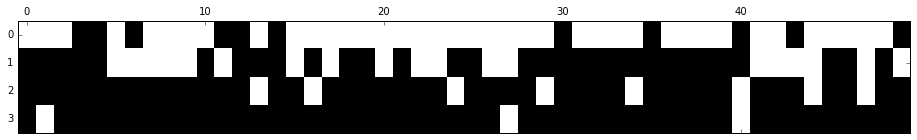

In [6]:
dX = 0.1 * np.random.randn(P, NS)

import scipy.stats as stats

ddelta = stats.beta.rvs(1.2, 1, size=(K,))
dpi = np.cumprod(ddelta)
print(ddelta, dpi)
dZ = stats.bernoulli.rvs(dpi[:, np.newaxis], size=(K, NS))

# plot states
plt.matshow(dZ, aspect='auto', cmap='gray');

# Generate trial set

In [7]:
dU, dS = np.meshgrid(range(NU), range(NS))
dU = dU.ravel()
dS = dS.ravel()

In [8]:
dlam_mean = np.tile(dA[dU] + np.sum(dB[dU] * dX[:, dS].T, axis=1) + np.sum(dC[dU] * dZ[:, dS].T, axis=1), Nrep)

dlam = stats.norm.rvs(loc=dlam_mean, scale=0.01)

In [9]:
dcount = stats.poisson.rvs(np.exp(dlam))
dcount.shape

(125000,)

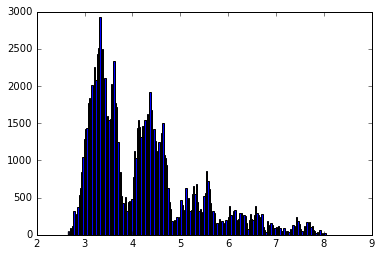

In [10]:
plt.hist(dlam, bins=200);

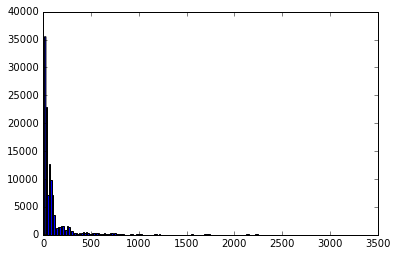

In [11]:
plt.hist(np.exp(dlam), bins=200);

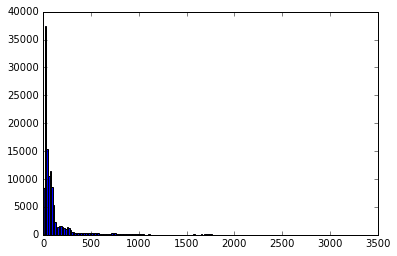

In [12]:
plt.hist(dcount, bins=200);

# Set up data

In [13]:
count = dcount.copy()
Xdat = np.tile(dX[:, dS], (1, Nrep)).T
unit = np.tile(dU, Nrep)
stim = np.tile(dS, Nrep)

# Run GLM to get inits

Here, we run a GLM on the observed data with $A$ and $B$ included (but not $C \cdot Z$) to get a rough starting point. This takes time, but is a net win in terms of saving SGD iterations.

In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
Xdf = pd.DataFrame(Xdat)
Xdf.columns = ['X' + str(c) for c in Xdf.columns]
dta = pd.concat([pd.DataFrame({'count': count, 'unit': unit, 'stim': stim}), Xdf], axis=1)
formula = 'count ~ -1 + C(unit) + C(unit) * (' + '+'.join(Xdf.columns) + ')'
mod = smf.glm(formula=formula, data=dta, family=sm.families.Poisson()).fit()

Now extract the model's fitted parameters into inits for $A$ and $B$

In [15]:
A_init = mod.params.values[:NU].astype('float32')
B_init = mod.params.values[NU:].reshape(P, NU).T.astype('float32')

# Define the model

## Constants

In [16]:
# define some needed constants
N = Xdat.shape[0]  # number of trials

In [17]:
N

125000

## Inputs and data

In [18]:
X = tf.constant(Xdat.astype('float32'))
U = tf.constant(unit)
S = tf.constant(stim)
counts = tf.constant(count)
allinds = tf.constant(np.arange(N))

In [19]:
X.get_shape()

TensorShape([Dimension(125000), Dimension(3)])

Make a node that produces `NB` indices from the range $[0, N - 1]$. These are the subset of data points we want to use.

In [20]:
NB = N
batch_inds = np.arange(N)
batch_counts = counts

## Generative (p) model

In [21]:
with tf.variable_scope("pmodel"):
    A = ed.models.Normal(mu=tf.zeros(NU), sigma=5 * tf.ones(NU), name='A')
    B = ed.models.Normal(mu=tf.zeros((NU, P)), sigma=3 * tf.ones((NU, P)), name='B')
    C = ed.models.Normal(mu=tf.zeros((NU, K)), sigma=3 * tf.ones((NU, K)), name='C')  
    
    delta = ed.models.Beta(a=3 * tf.ones(K), b=tf.ones(K), name='delta')
    
    log_delta = tf.log(delta + 1e-6 * tf.ones(K)) # work on a log scale to prevent underflow

    pi = tf.clip_by_value(tf.exp(tf.cumsum(log_delta), name='pi'), 1e-6, 1. - 1e-6)

    Z = ed.models.Bernoulli(p=tf.tile(tf.expand_dims(pi, 0), [NS, 1]), name='Z')

    sig = ed.models.Normal(mu=[-7.0], sigma=[1.], name='sig')

    lam_vars = (tf.gather(A, U) + tf.reduce_sum(tf.gather(B, U) * X, 1) + 
           tf.reduce_sum(tf.gather(C, U) * tf.gather(tf.to_float(Z), S), 1))
    lam = ed.models.Normal(mu=tf.gather(lam_vars, batch_inds), 
                           sigma=tf.exp(sig), name='lam')

    cnt = ed.models.Poisson(lam=tf.exp(lam), value=tf.ones(NB), name='cnt')

# Recognition (q) model

In [22]:
with tf.variable_scope("qmodel"):
    q_A = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(A_init), 
                                            sigma=tf.Variable(0.5 + tf.random_uniform((NU,))),
                                            name='A')
    tf.scalar_summary('q_A', tf.reduce_mean(q_A.mean()))

    q_B = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(B_init), 
                                            sigma=tf.Variable(0.5 + tf.random_uniform((NU, P))),
                                            name='B')
    tf.scalar_summary('q_B', tf.reduce_mean(q_B.mean()))

    q_C = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(tf.random_normal((NU, K))), 
                                            sigma=tf.Variable(0.5 + tf.random_uniform((NU, K))),
                                            name='C')
    tf.scalar_summary('q_C', tf.reduce_mean(q_C.mean()))
    
    Zlogit = tf.clip_by_value(tf.Variable(-0.0 + tf.zeros((NS, K))), -10, 10, name='Z_logit_clip')
    tf.scalar_summary('max_Z_logit', tf.reduce_max(Zlogit))
    tf.scalar_summary('min_Z_logit', tf.reduce_min(Zlogit))
    q_Z = ed.models.BernoulliWithSigmoidP(p=Zlogit, name='Z')
    tf.scalar_summary('q_Z', tf.reduce_mean(q_Z.mean()))
    tf.scalar_summary('max_q_Z', tf.reduce_max(q_Z.mean()))
    tf.scalar_summary('min_q_Z', tf.reduce_min(q_Z.mean()))

    a_var = 1. + tf.Variable(tf.random_uniform((K,)))
    b_var = 1. + tf.Variable(tf.random_uniform((K,)))
    tf.scalar_summary('max_a', tf.reduce_max(a_var))
    tf.scalar_summary('max_b', tf.reduce_max(b_var))
    tf.scalar_summary('min_a', tf.reduce_min(a_var))
    tf.scalar_summary('min_b', tf.reduce_min(b_var))
    q_delta = ed.models.BetaWithSoftplusAB(a=a_var,
                                           b=b_var,
                                           name='delta')
    
    tf.scalar_summary('min_q_delta', tf.reduce_min(q_delta.value()))
    tf.scalar_summary('max_q_delta', tf.reduce_max(q_delta.value()))
    tf.scalar_summary('min_pi', tf.reduce_min(tf.reduce_prod(q_delta.value())))

    lam_mu = tf.Variable(2 + tf.random_normal((N,)))
    tf.scalar_summary('lam_mu_mean', tf.reduce_mean(tf.gather(lam_mu, batch_inds)))
    lam_sig = tf.Variable(3 * tf.random_uniform((N,)) + 2)
    q_lam = ed.models.NormalWithSoftplusSigma(mu=tf.gather(lam_mu, batch_inds),
                                              sigma=tf.gather(lam_sig, batch_inds),
                                              name='lam')

    q_sig = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(-0.1 * tf.random_uniform((1,))),
                                              sigma=tf.Variable(tf.random_uniform((1,))),
                                              name='sig')

# ELBO

In [23]:
def make_ELBO(latent_vars, data, scale):
    from edward.util import copy
    p_log_prob = 0.0
    q_log_prob = 0.0
    z_sample = {}
    scope = "ELBO"

    for z, qz in latent_vars.items():
        # Copy q(z) to obtain new set of posterior samples.
        qz_copy = copy(qz, scope=scope)
        z_sample[z] = qz_copy.value()
        z_log_prob = tf.reduce_sum(qz.log_prob(tf.stop_gradient(z_sample[z])))
        if z in scale:
            z_log_prob *= scale[z]

        q_log_prob += z_log_prob

    dict_swap = z_sample
    for x, qx in data.items():
        if isinstance(x, ed.RandomVariable):
            if isinstance(qx, ed.RandomVariable):
                qx_copy = copy(qx, scope=scope)
                dict_swap[x] = qx_copy.value()
            else:
                dict_swap[x] = qx

            for z in latent_vars.keys():
                z_copy = copy(z, dict_swap, scope=scope)
                z_log_prob = tf.reduce_sum(z_copy.log_prob(dict_swap[z]))
                if z in scale:
                    z_log_prob *= scale[z]

                p_log_prob += z_log_prob

            for x in data.keys():
                if isinstance(x, ed.RandomVariable):
                    x_copy = copy(x, dict_swap, scope=scope)
                    x_log_prob = tf.reduce_sum(x_copy.log_prob(dict_swap[x]))
                if x in scale:
                    x_log_prob *= scale[x]

                p_log_prob += x_log_prob

    return tf.reduce_mean(p_log_prob - q_log_prob)

In [24]:
elbo = make_ELBO({A: q_A, B: q_B, C: q_C, Z: q_Z, sig: q_sig, delta: q_delta, lam: q_lam}, 
                 {cnt: tf.cast(batch_counts, 'float32')}, 
                 {lam: N/NB, cnt: N/NB})

tf.scalar_summary('ELBO', elbo)

<tf.Tensor 'ScalarSummary:0' shape=() dtype=string>

# Do variational inference

In [25]:
data = {cnt: batch_counts}
inference_lam = ed.KLqp({lam: q_lam, sig: q_sig}, data={cnt: batch_counts, Z: q_Z, 
                                            delta: q_delta, A: q_A, B: q_B, 
                                            C: q_C, delta: q_delta})
inference_coeffs = ed.KLqp({A: q_A, B: q_B, C: q_C}, 
                    data={cnt: batch_counts, Z: q_Z, delta: q_delta, lam: q_lam, sig: q_sig})
inference_latents = ed.KLqp({Z: q_Z, delta: q_delta}, 
                    data={cnt: batch_counts, A: q_A, B: q_B, C: q_C, sig: q_sig, lam: q_lam})

# Notes on inference:

- The `logdir` keyword specifies the place to put the log file (assuming you've instrumented the code to save events, etc.). If a subdirectory is given, pointing Tensorboard at the parent directory allows you to compare across subdirectories (runs).
    - I'm using the `jmp/instrumented` branch of the `jmxpearson/edward` fork
- The learning rate is a difficult tradeoff: 1e-2 drastically speeds convergence but can run into NaNs; 1e-3 (the default) is much slower.
    - **TO DO**: Does regularizing emergence of `NaN`s help with this?
- I'm currently using "all" the data, which appears to be faster (run-time, wise) than using minibatches. (Not entirely sure why this is, except perhaps that switching data into and out of the graph has a cost.) I've also found that minibatches need to be fairly substantial to be effective, since most variables ($\lambda$, $A$, $B$, $C$) are unit-specific (i.e., local), so unless you have several observations from that unit, convergence can be slow.
    - Ultimately, it might speed things to have a smarter minibatch selection (i.e., all observations for a single unit) when updating the local variables.
- I've used `n_samples` = 1, 5, 10, and 25, which all seem pretty similar after 10k iterations. 
- I've noticed no difference below in how many steps one takes along each coordinate before switching (number of inner loop iterations), either in runtime or convergence. Perhaps this matters in the final stages, but I would suspect that then it favors tighter inner loops.

In [26]:
# Initialize each inference step
debug = False
inf_list = [inference_lam, inference_coeffs, inference_latents]
for inf in inf_list:
    if inf is inference_lam:
        logdir = 'data/run3'
    else:
        logdir = None
        
    inf.initialize(n_print=100, n_samples=1,  
                  logdir=logdir,
                  optimizer=tf.train.AdamOptimizer(1e-1),
                  scale={lam: N/NB, cnt: N/NB},
                  debug=debug)

In [27]:
init = tf.initialize_all_variables()
init.run({})

In [28]:
n_iter = 200000
for _ in range(n_iter):
    for inf in inf_list:
        for _ in range(1):  # make multiple steps along each set of coords
            info_dict = inf.update()
        if inf is inference_lam:
            inf.print_progress(info_dict)

Iteration    1 [  0%]: Loss = 11048934400.000
Iteration  100 [ 10%]: Loss = 55194376.000
Iteration  200 [ 20%]: Loss = 50528872.000
Iteration  300 [ 30%]: Loss = 43012584.000
Iteration  400 [ 40%]: Loss = 20261172.000
Iteration  500 [ 50%]: Loss = 17102738.000
Iteration  600 [ 60%]: Loss = 14567043.000
Iteration  700 [ 70%]: Loss = 15334546.000
Iteration  800 [ 80%]: Loss = 12193222.000
Iteration  900 [ 90%]: Loss = 11420746.000
Iteration 1000 [100%]: Loss = 10370276.000
Iteration 1100 [110%]: Loss = 8514990.000
Iteration 1200 [120%]: Loss = 7344050.500
Iteration 1300 [130%]: Loss = 6899350.000
Iteration 1400 [140%]: Loss = 7989767.000
Iteration 1500 [150%]: Loss = 6472684.000
Iteration 1600 [160%]: Loss = 5718712.000
Iteration 1700 [170%]: Loss = 5418079.500
Iteration 1800 [180%]: Loss = 5185374.500
Iteration 1900 [190%]: Loss = 5664501.500
Iteration 2000 [200%]: Loss = 4901086.500
Iteration 2100 [210%]: Loss = 6120925.500
Iteration 2200 [220%]: Loss = 4673754.000
Iteration 2300 [229%

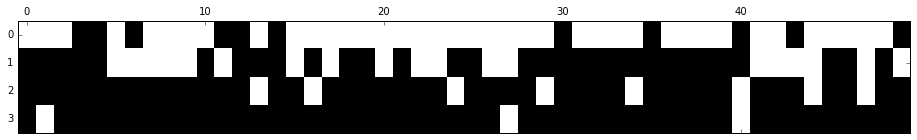

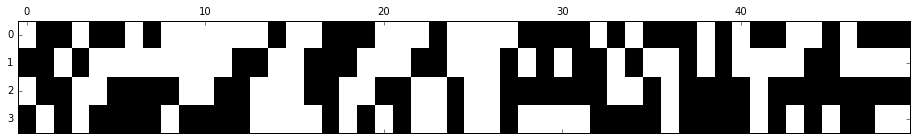

In [29]:
Zmat = q_Z.mean().eval()

plt.matshow(dZ, aspect='auto', cmap='gray')
plt.matshow(Zmat.T, aspect='auto', cmap='gray')

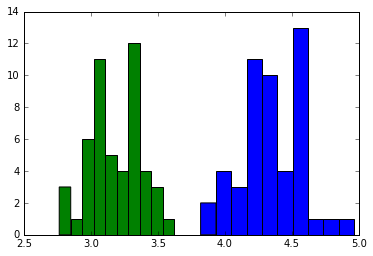

In [30]:
plt.hist(q_A.mean().eval().ravel()); plt.hist(dA.ravel());

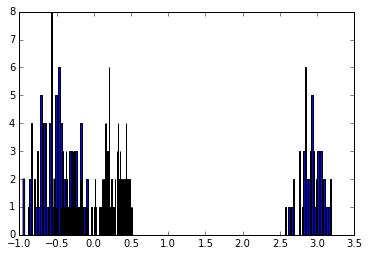

In [31]:
plt.hist(q_B.mean().eval().ravel(), 200), plt.hist(dB.ravel(), 200);

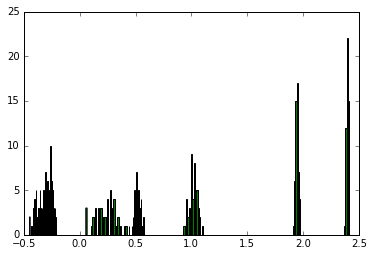

In [32]:
plt.hist(q_C.mean().eval().ravel(), 200), plt.hist(dC.ravel(), 200);

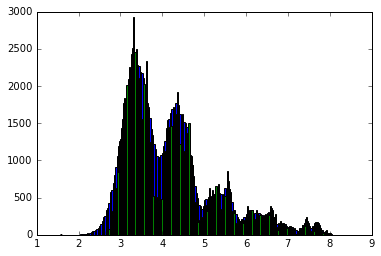

In [33]:
plt.hist(lam_mu.eval(), 200), plt.hist(dlam, 200);

In [34]:
lam_mu.value().eval()

array([ 4.16785526,  3.62882924,  3.05687499, ...,  4.22871065,
        4.16520405,  3.94072247], dtype=float32)

In [35]:
q_lam.mean().eval()

array([ 4.16785526,  3.62882924,  3.05687499, ...,  4.22871065,
        4.16520405,  3.94072247], dtype=float32)

In [36]:
q_sig.mean().eval()

array([-0.03758294], dtype=float32)

In [37]:
q_delta._value.eval()

array([ 0.9999975 ,  0.        ,  0.        ,  0.99999946], dtype=float32)

In [38]:
q_delta.mean().eval()

array([  1.00000000e+00,   4.28659569e-23,   4.57887118e-23,
         1.00000000e+00], dtype=float32)